In [1]:
import numpy as np
import sympy
emc = float( sympy.S.EulerGamma.n(10) )
from tteVAMP.problem import *
from tteVAMP.denoisers import *
from tteVAMP.em import *
from tteVAMP.simulations import sim_model
from tteVAMP.utils import plot_metrics
from scipy.sparse.linalg import cg as con_grad
from numpy.random import binomial
import pickle
import os
from datetime import datetime

EM VAMP loop

In [2]:
def save_results(output_dir, n, m, **kwargs):
    print("Saving results!!\n\n\n\n")
    """
    Save results as a pickle file in the specified output directory with the current date and time in the filename.

    Parameters:
    output_dir (str): Directory where the results should be saved.
    **kwargs: Results to be saved, passed as keyword arguments.
    """
    os.makedirs(output_dir, exist_ok=True)  # Ensure the output directory exists

    # Get current date and time
    current_time = datetime.now().strftime("%Y%m%d_%H%M")

    # Define the output filename with the date and time
    output_filename = f'vamp_em_results_{n}x{m}_{current_time}.pkl'
    output_filepath = os.path.join(output_dir, output_filename)

    # Save the results dictionary as a pickle file
    with open(output_filepath, 'wb') as f:
        pickle.dump(kwargs, f)


In [3]:
# prior, y, alpha, mu, maxiter, beta_true
def infere_con_grad(X, y, gam1, r1, tau1, p1, problem, maxiter, beta_true, update_mu, update_alpha):

    alpha = problem.prior_instance.distribution_parameters['alpha']
    mu = problem.prior_instance.distribution_parameters['mu'][0][0]

    #computing SVD decomposition of X
    [n,m] = X.shape
    Sigma2_u_prev = np.zeros((m,1))
    x2_hat_prev = np.zeros((m,1))
    # u, s, vh = np.linalg.svd(X, full_matrices=False)
    # print("s.shape = ", s.shape)
    Xbeta_true = X @ beta_true

    #storing measure of recovery quality
    l2_errs_x = []
    corrs_x = []
    l2_errs_z = []
    corrs_z = []
    mus = [mu]
    alphas = [alpha]
    actual_xis = []
    predicted_xis = []
    dl_dmus = []
    z1_hats = []
    x1_hats = []
    
    for it in range(maxiter):
        print("**** iteration = ", it, " **** \n" )
        # Denoising x (the effect sizes)
        print("->DENOISING")
        ############################################################
        # Conditional expectation of x given r and the parameters of the prior distribution of x
        # This is applied elementwise to r1
        ############################################################
        x1_hat = den_beta(r1, gam1, problem)
        x1_hats.append(x1_hat)
        ############################################################
        print("x1_hat[2] = ", x1_hat[2])
        if np.linalg.norm(x1_hat) != 0:
            # Cosine similarity
            # corr = np.corrcoef(np.squeeze(x1_hat, axis=-1), np.squeeze(beta_true, axis=-1))
            # print("corr(x1_hat, beta_true) = ", corr[0, 1])
            # corrs_x.append(corr[0, 1])
            corr = np.dot(x1_hat.transpose(), beta_true) / np.linalg.norm(x1_hat) / np.linalg.norm(beta_true)
            print("corr(x1_hat, beta_true) = ", corr[0][0])
            corrs_x.append(corr[0][0])
            l2_err = np.linalg.norm(x1_hat - beta_true) / np.linalg.norm(beta_true)
            print("l2 error for x1_hat = ", l2_err)
            l2_errs_x.append(l2_err)
        ############################################################
        alpha1 = np.mean( der_den_beta(r1, gam1, problem) )
        print("alpha1 = ", alpha1)
        gam2 = gam1 * (1-alpha1) / alpha1
        r2 = (x1_hat - alpha1 * r1) / (1-alpha1)
        print("true gam2 = ", 1.0 / np.var(r2 - beta_true))
        print("gam2 = ", gam2)
        # Denoising z (the genetic predictor)
        z1_hat = den_z(p1, tau1, y, problem)
        z1_hats.append(z1_hat)
        ############################################################
        # Cosine similarity
        # corr = np.corrcoef(np.squeeze(z1_hat, axis=-1), np.squeeze(Xbeta_true, axis=-1))
        # print("corr(z1_hat, X*beta_true) = ", corr[0, 1])
        # corrs_z.append(corr[0, 1])
        corr = np.dot(z1_hat.transpose(), Xbeta_true) / np.linalg.norm(z1_hat) / np.linalg.norm(Xbeta_true)
        print("corr(z1_hat, X*beta_true) = ", corr[0][0])
        corrs_z.append(corr[0][0])
        l2_err = np.linalg.norm(z1_hat - Xbeta_true) / np.linalg.norm(Xbeta_true)
        print("l2 error for z1_hat = ", l2_err)
        l2_errs_z.append(l2_err)
        ############################################################
        beta_1 = np.mean(der_den_z(p1, tau1, y, problem) )
        print("v1 = ", beta_1)
        tau2 = tau1 * (1-beta_1) / beta_1
        p2 = (z1_hat - beta_1 * p1) / (1-beta_1)
        print("true tau2 = ", 1.0 / np.var(p2 - Xbeta_true))
        print("tau2 =", tau2)

        predicted_xi = tau1 / beta_1
        predicted_xis.append(predicted_xi)
        actual_xi = 1 / np.var(X@beta_true-z1_hat)
        actual_xis.append(actual_xi)

        
        # LMMSE estimation of x
        print("->LMMSE")
        # dk = 1.0 / (tau2 * s * s + gam2)
        # x2_hat = vh.transpose() @ np.diag(dk) @ (tau2 * np.diag(s).transpose() @ u.transpose() @ p2 + gam2 * vh @ r2)

        # Conjugate gradient solver
        # We are solving the system A2x2 = y2;
        A2 = tau2*X.transpose()@X + gam2*np.eye(X.shape[1])
        y2 = tau2*X.transpose()@p2 + gam2*r2
        x2_hat, ret = con_grad(A2, y2, maxiter=500, x0=x2_hat_prev)
        x2_hat_prev = x2_hat
        if ret > 0: 
            print(f"WARNING: CG 1 convergence after {ret} iterations not achieved!")
        x2_hat.resize((m,1))

        ############################################################
        # Cosine similarity
        print("corr(x2_hat, beta_true) = ", np.dot(x2_hat.transpose(), beta_true) / np.linalg.norm(x2_hat) / np.linalg.norm(beta_true))
        print("l2 error for x2_hat = ", np.linalg.norm(x2_hat - beta_true) / np.linalg.norm(beta_true))
        ############################################################

        # Generate iid random vector [-1,1] of size M
        u = binomial(p=1/2, n=1, size=m) * 2 - 1

        # Hutchinson trace estimator
        # Sigma2 = (gamw * R + gam2 * I)^(-1)
        # Conjugate gradient for solving linear system (gamw * R + gam2 * I)^(-1) @ u

        Sigma2_u, ret = con_grad(A2,u, maxiter=500, x0=Sigma2_u_prev)
        Sigma2_u_prev = Sigma2_u

        if ret > 0: 
            print(f"WARNING: CG 2 convergence after {ret} iterations not achieved!")

        TrSigma2 = u.T @ Sigma2_u # Tr[Sigma2] = u^T @ Sigma2 @ u 

        alpha2 = gam2 * TrSigma2 / m
        # alpha2 = np.sum( gam2 / (tau2 * s * s + gam2) ) / m
        print("alpha2 = ", alpha2)
        gam1 = gam2 * (1-alpha2) / alpha2
        r1 = (x2_hat - alpha2 * r2) / (1-alpha2)
        print("true gam1 = ", 1.0 / np.var(r1 - beta_true))
        print("gam1 = ", gam1)
        
        # LMMSE estimation of z
        z2_hat = np.matmul(X, x2_hat)

        mu, alpha = update_params(y, mu, z1_hat, alpha, predicted_xi, update_Weibull_alpha, update_Weibull_mu, mus, alphas, update_alpha, update_mu, it)
        problem.prior_instance.distribution_parameters['alpha'] = alpha
        problem.prior_instance.distribution_parameters['mu'] = np.full((y.shape[0],1), mu)

    
        ############################################################
        # Cosine similarity
        z_hat = X@x1_hat
        print("corr(z2_hat, beta_true) = ", np.dot(z_hat.transpose(), Xbeta_true) / np.linalg.norm(z_hat) / np.linalg.norm(Xbeta_true))
        print("l2 error for z2_hat = ", np.linalg.norm(z_hat - Xbeta_true) / np.linalg.norm(Xbeta_true))
        ############################################################

        beta2 = (1-alpha2) * m / n
        tau1 = tau2 * (1-beta2) / beta2
        p1 = (z2_hat - beta2 * p2) / (1-beta2)
        print("true tau1 = ", 1.0 / np.var(p1 - Xbeta_true))
        print("tau1 = ", tau1)
        print("\n")
            

    save_results('outputs', 
                 n,
                 m,
                 x1_hat=x1_hat, 
                 gam1=gam1, 
                 corrs_x=corrs_x, 
                 l2_errs_x=l2_errs_x, 
                 corrs_z=corrs_z, 
                 l2_errs_z=l2_errs_z, 
                 mus=mus, 
                 alphas=alphas, 
                 actual_xis=actual_xis, 
                 predicted_xis=predicted_xis, 
                 dl_dmus=dl_dmus, 
                 z1_hats=z1_hats, 
                 x1_hats=x1_hats)
    return x1_hat, gam1, corrs_x, l2_errs_x, corrs_z, l2_errs_z, mus, alphas, actual_xis, predicted_xis, dl_dmus, z1_hats, x1_hats

Experiments with synthetic genetic matrices X of varying sizes

Weibull
gam1 =  0.01
tau1 =  0.1
alpha =  2.9361235628007685
**** iteration =  0  **** 

->DENOISING
x1_hat[2] =  [0.]
B / (A+B) =  [0.39880656]
gam1 / (gam1 + 1/sigma) =  0.009900990099009901
alpha1 part I =  [0.00394858]
alpha2 part II =  [0.]
alpha1 =  0.003948579767497003
true gam2 =  2.3722202522924425
gam2 =  2.5225561565998147
corr(z1_hat, X*beta_true) =  0.5290047533799667
l2 error for z1_hat =  0.9605651047308081
v1 =  0.050136652118083234
true tau2 =  6.2399873309118306
tau2 = 1.8945488136000233
->LMMSE
corr(x2_hat, beta_true) =  [[0.54551222]]
l2 error for x2_hat =  0.8830818166998755
alpha2 =  0.7691341292577515
true gam1 =  2.203799375979793
gam1 =  0.7571788865378408
corr(z2_hat, beta_true) =  [[nan]]
l2 error for z2_hat =  1.0
true tau1 =  6.461696614003461
tau1 =  6.311726143841403


**** iteration =  1  **** 

->DENOISING
x1_hat[2] =  [-0.06921171]
corr(x1_hat, beta_true) =  0.5777301021088953
l2 error for x1_hat =  0.8952046987415914
B / (A+B) =  [0.39780906]
gam1 / (

/var/folders/3b/v9q3pbyx1r1gb74yk77xgx900000gq/T/ipykernel_2578/3020076226.py:141: RuntimeWarning: invalid value encountered in divide
  print("corr(z2_hat, beta_true) = ", np.dot(z_hat.transpose(), Xbeta_true) / np.linalg.norm(z_hat) / np.linalg.norm(Xbeta_true))


v1 =  0.8432539298376714
true tau2 =  5.4797056809444
tau2 = 1.1732388477316888
->LMMSE
corr(x2_hat, beta_true) =  [[0.62693262]]
l2 error for x2_hat =  0.882599155826949
alpha2 =  0.8775956811142168
true gam1 =  1.4236831839001574
gam1 =  0.5077074008083816
corr(z2_hat, beta_true) =  [[0.61325296]]
l2 error for z2_hat =  0.8607374943056829
true tau1 =  6.6197708786192075
tau1 =  8.411707650981734


**** iteration =  2  **** 

->DENOISING
x1_hat[2] =  [-0.18697257]
corr(x1_hat, beta_true) =  0.6323073835786696
l2 error for x1_hat =  0.8649520915966746
B / (A+B) =  [0.40082391]
gam1 / (gam1 + 1/sigma) =  0.33674133358778113
alpha1 part I =  [0.13497398]
alpha2 part II =  [0.03376081]
alpha1 =  0.14165809009840025
true gam2 =  2.468382183362073
gam2 =  3.07632652521527
corr(z1_hat, X*beta_true) =  0.07212464344207566
l2 error for z1_hat =  1.2293999197754877
v1 =  0.7567845605582303
true tau2 =  5.22061030484805
tau2 = 2.7033547979363166
->LMMSE
corr(x2_hat, beta_true) =  [[0.64697885]]


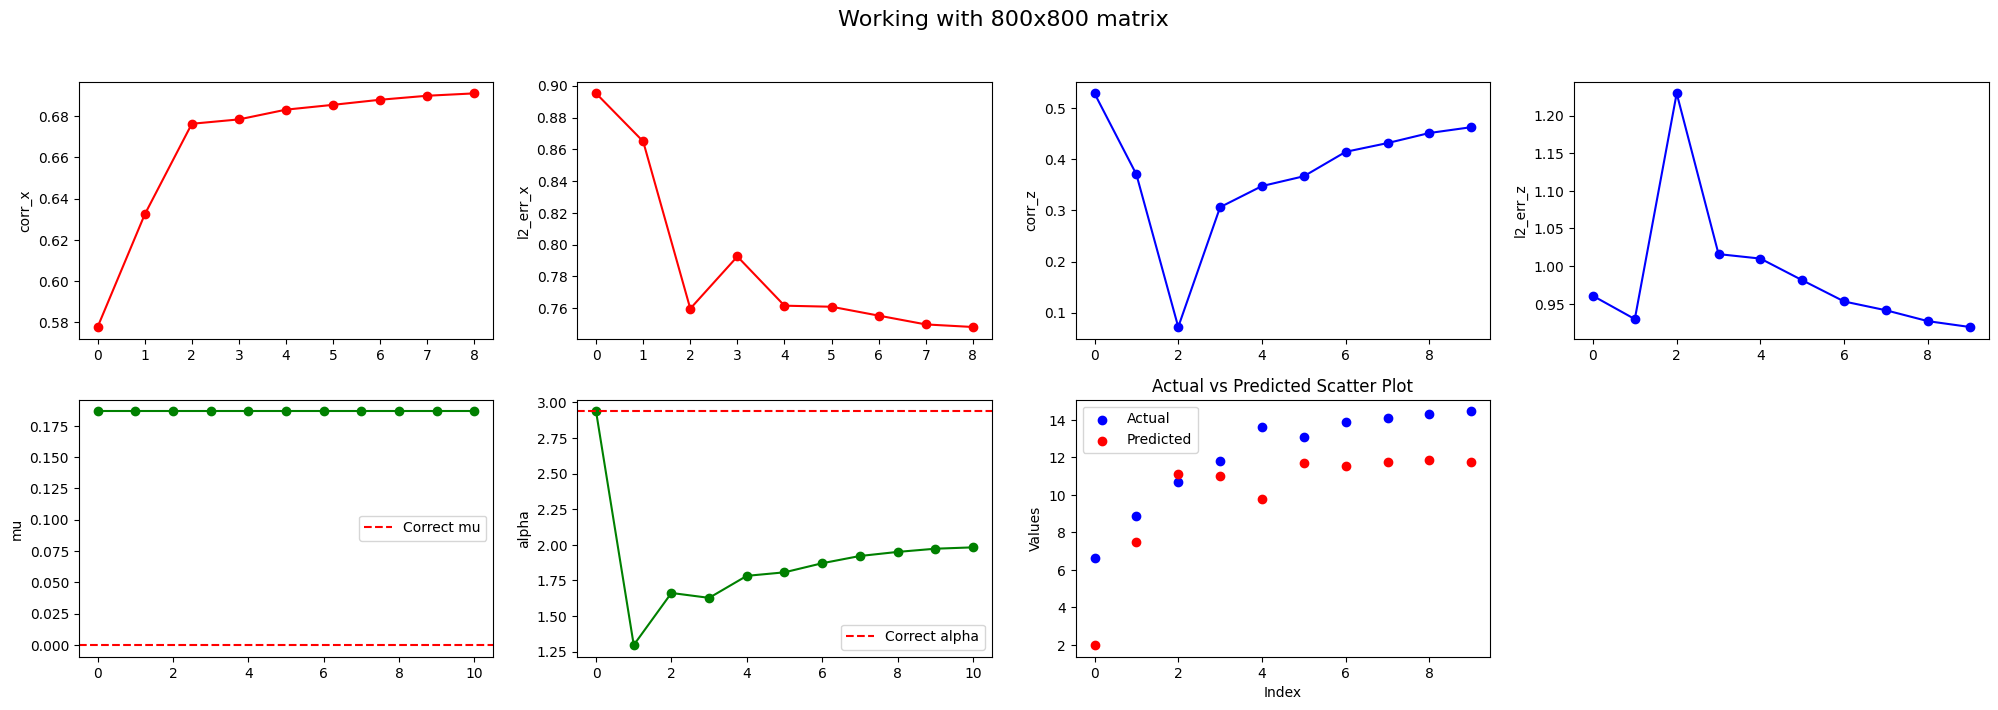

In [7]:
np.random.seed(42)
n=800
m=800
p=0.4
la=0.4
# This is where the sigma is defined. Note that the scope of this definition extends to gvamp
sigma=1
omega=1
h2=0.5
gam1 = 1e-2
tau1 = 1e-1
maxiter = 10
mu=np.full((n,1), 0) 
problem_instance = Problem(n=n, m=m, la=la, sigmas = [sigma], omegas=[omega], model='Weibull', mu=mu)
X,beta,y,alpha = sim_model(problem_instance,h2,p )
problem_instance.prior_instance.distribution_parameters['mu'] = np.mean(np.log(y)).reshape(-1, 1)
print("gam1 = ", gam1)
print("tau1 = ", tau1)
print("alpha = ", alpha)

# we start with an initialization that compleately complies with the assumptions
r1 = np.zeros((m,1))
#r1 = beta + random.normal(loc=0.0, scale=np.sqrt(1.0/gam1), size=[m,1])
p1 = np.zeros((n,1)) 
#p1 = X @ beta + random.normal(loc=0.0, scale=np.sqrt(1.0/tau1), size=[n,1])
problem_instance.prior_instance.distribution_parameters['alpha']=alpha

est, gam1, corrs_x, l2_errs_x, corrs_z, l2_errs_z, mus, alphas, a, ps, dl_dmus, z1_hats, x1_hats =  infere_con_grad(X, y, gam1, r1, tau1, p1, problem_instance, maxiter, beta, False, True)
plot_metrics(corrs_x, l2_errs_x, corrs_z, l2_errs_z, mus, alphas, dl_dmus, a, ps, mu[0][0], alpha, n, m)

Weibull
gam1 =  0.01
tau1 =  0.1
alpha =  2.904162347864121
**** iteration =  0  **** 

->DENOISING
x1_hat[2] =  [0.]
B / (A+B) =  [0.39880656]
gam1 / (gam1 + 1/sigma) =  0.009900990099009901
alpha1 part I =  [0.00394858]
alpha2 part II =  [0.]
alpha1 =  0.003948579767497003
true gam2 =  2.4331914329104647
gam2 =  2.5225561565998147
corr(z1_hat, X*beta_true) =  0.38829783677699625
l2 error for z1_hat =  1.008790725422278
v1 =  0.056947370418809304
true tau2 =  5.919219577351003
tau2 = 1.6560073321132796
->LMMSE
corr(x2_hat, beta_true) =  [[0.54024184]]
l2 error for x2_hat =  0.8904655572401378
alpha2 =  0.7981800655774349
true gam1 =  2.045996333718118
gam1 =  0.637828655535149
corr(z2_hat, beta_true) =  [[nan]]
l2 error for z2_hat =  1.0
true tau1 =  6.424608220460308
tau1 =  6.5493631475241605


**** iteration =  1  **** 

->DENOISING
x1_hat[2] =  [-0.05443837]
corr(x1_hat, beta_true) =  0.5569621383018644
l2 error for x1_hat =  0.9053448405177493
B / (A+B) =  [0.34344406]
gam1 / (ga

/var/folders/3b/v9q3pbyx1r1gb74yk77xgx900000gq/T/ipykernel_2578/3020076226.py:141: RuntimeWarning: invalid value encountered in divide
  print("corr(z2_hat, beta_true) = ", np.dot(z_hat.transpose(), Xbeta_true) / np.linalg.norm(z_hat) / np.linalg.norm(Xbeta_true))


corr(z1_hat, X*beta_true) =  0.10809838005088175
l2 error for z1_hat =  1.0151061630760287
v1 =  0.8678477558422353
true tau2 =  5.154387282841778
tau2 = 0.9973097607534974
->LMMSE
corr(x2_hat, beta_true) =  [[0.62312228]]
l2 error for x2_hat =  0.8918113394563718
alpha2 =  0.8891419128987519
true gam1 =  1.3639781912748754
gam1 =  0.4342352327404577
corr(z2_hat, beta_true) =  [[0.25591433]]
l2 error for z2_hat =  0.9673053422092528
true tau1 =  6.391465444675609
tau1 =  7.998964546619691


**** iteration =  2  **** 

->DENOISING
x1_hat[2] =  [-0.00013958]
corr(x1_hat, beta_true) =  0.6322557651295801
l2 error for x1_hat =  0.8768930439262331
B / (A+B) =  [0.35999625]
gam1 / (gam1 + 1/sigma) =  0.30276430450724945
alpha1 part I =  [0.10899401]
alpha2 part II =  [0.00145102]
alpha1 =  0.12508363354335192
true gam2 =  2.490283121981918
gam2 =  3.037323918840784
corr(z1_hat, X*beta_true) =  -0.25945729321838534
l2 error for z1_hat =  1.359474472714714
v1 =  0.7638026615504266
true tau2 = 

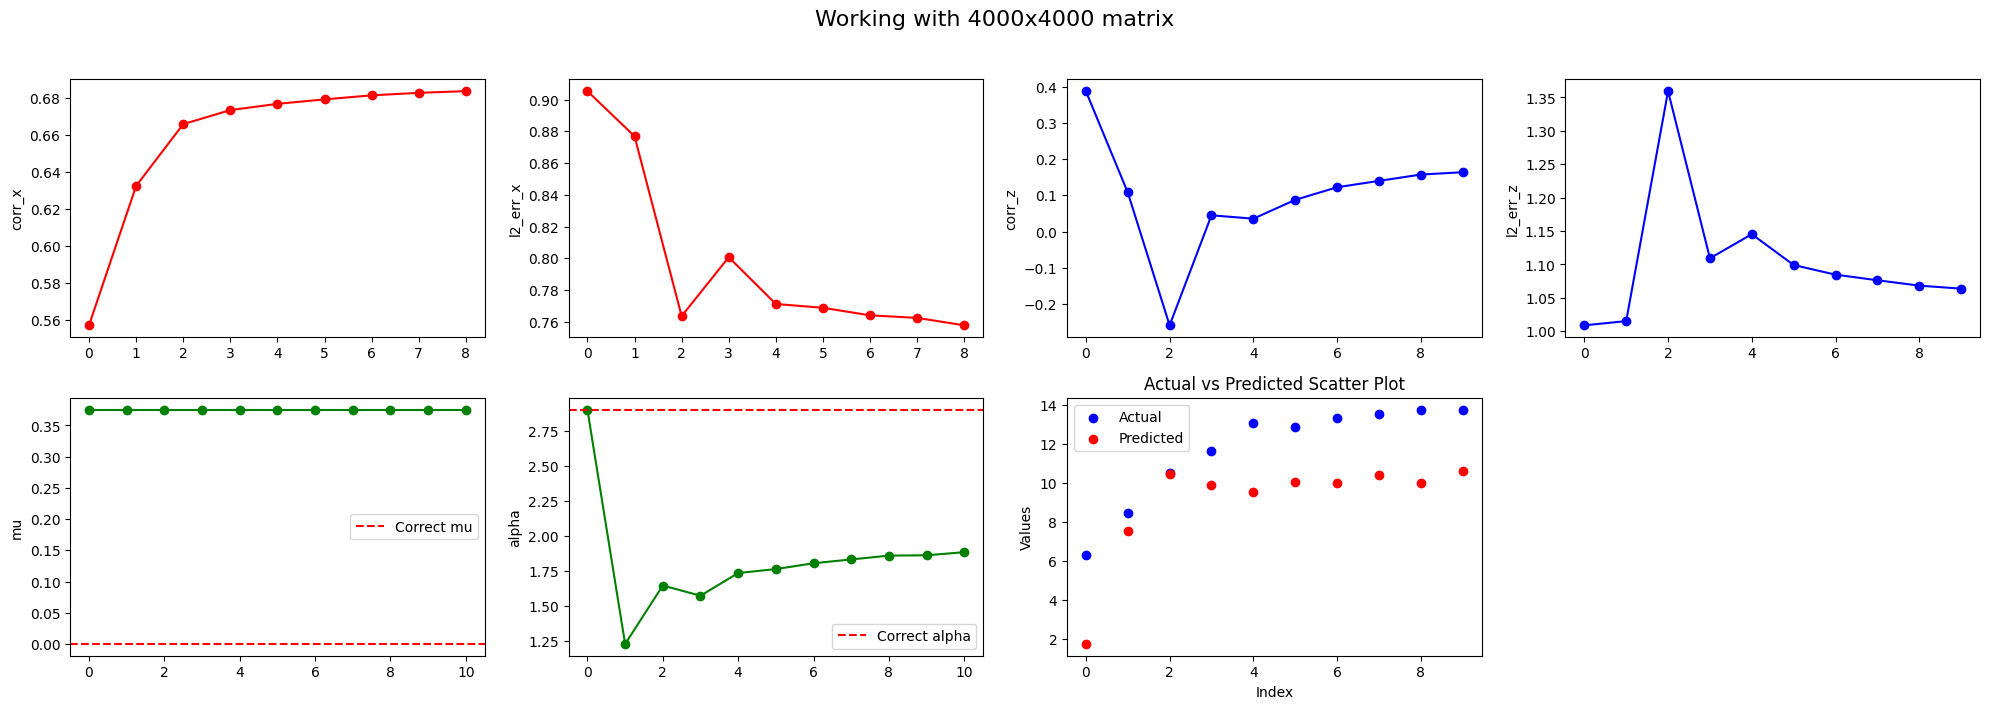

In [8]:
np.random.seed(42)
n=4000
m=4000
p=0.4
la=0.4
# This is where the sigma is defined. Note that the scope of this definition extends to gvamp
sigma=1
omega=1
h2=0.5
gam1 = 1e-2
tau1 = 1e-1

maxiter = 10
mu=np.full((n,1), 0) 
problem_instance = Problem(n=n, m=m, la=la, sigmas = [sigma], omegas=[omega], model='Weibull', mu=mu)
X,beta,y,alpha = sim_model(problem_instance,h2,p )
problem_instance.prior_instance.distribution_parameters['mu'] = np.mean(np.log(y)).reshape(-1, 1)

print("gam1 = ", gam1)
print("tau1 = ", tau1)
print("alpha = ", alpha)

# we start with an initialization that compleately complies with the assumptions
r1 = np.zeros((m,1))
#r1 = beta + random.normal(loc=0.0, scale=np.sqrt(1.0/gam1), size=[m,1])
p1 = np.zeros((n,1)) 
#p1 = X @ beta + random.normal(loc=0.0, scale=np.sqrt(1.0/tau1), size=[n,1])
problem_instance.prior_instance.distribution_parameters['alpha']=alpha

est, gam1, corrs_x, l2_errs_x, corrs_z, l2_errs_z, mus, alphas, a, ps, dl_dmus, z1_hats, x1_hats =  infere_con_grad(X, y, gam1, r1, tau1, p1, problem_instance, maxiter, beta, False, True)
plot_metrics(corrs_x, l2_errs_x, corrs_z, l2_errs_z, mus, alphas, dl_dmus, a, ps, mu[0][0], alpha, n, m)

Weibull
gam1 =  0.01
tau1 =  0.1
alpha =  2.9124599559682234
**** iteration =  0  **** 

->DENOISING
x1_hat[2] =  [0.]
B / (A+B) =  [0.39880656]
gam1 / (gam1 + 1/sigma) =  0.009900990099009901
alpha1 part I =  [0.00394858]
alpha2 part II =  [0.]
alpha1 =  0.003948579767497003
true gam2 =  2.4506245591871925
gam2 =  2.5225561565998147
corr(z1_hat, X*beta_true) =  0.46295190680347287
l2 error for z1_hat =  0.9827314621686579
v1 =  0.05347908629107484
true tau2 =  6.073114563525588
tau2 = 1.7698898379774504
->LMMSE
corr(x2_hat, beta_true) =  [[0.54679601]]
l2 error for x2_hat =  0.8846901593483059
alpha2 =  0.7879811179523335
true gam1 =  2.0958122463221613
gam1 =  0.678733949380122
corr(z2_hat, beta_true) =  [[nan]]
l2 error for z2_hat =  1.0
true tau1 =  6.578962983116566
tau1 =  6.577903626849613


**** iteration =  1  **** 

->DENOISING
x1_hat[2] =  [-0.10457074]
corr(x1_hat, beta_true) =  0.5671983800684032
l2 error for x1_hat =  0.8991428547367663
B / (A+B) =  [0.3971039]
gam1 / (ga

/var/folders/3b/v9q3pbyx1r1gb74yk77xgx900000gq/T/ipykernel_2578/3020076226.py:141: RuntimeWarning: invalid value encountered in divide
  print("corr(z2_hat, beta_true) = ", np.dot(z_hat.transpose(), Xbeta_true) / np.linalg.norm(z_hat) / np.linalg.norm(Xbeta_true))


corr(z1_hat, X*beta_true) =  0.2588442946396098
l2 error for z1_hat =  0.9706504631383561
v1 =  0.8591903994460807
true tau2 =  5.185716832693968
tau2 = 1.0780287847443504
->LMMSE
corr(x2_hat, beta_true) =  [[0.62654471]]
l2 error for x2_hat =  0.8860339194133615
alpha2 =  0.8844255468717309
true gam1 =  1.3460748604694166
gam1 =  0.46012002039778993
corr(z2_hat, beta_true) =  [[0.61324066]]
l2 error for z2_hat =  0.874544778109867
true tau1 =  6.567434717802682
tau1 =  8.249541067980037


**** iteration =  2  **** 

->DENOISING
x1_hat[2] =  [-0.10790281]
corr(x1_hat, beta_true) =  0.6322130040405795
l2 error for x1_hat =  0.8712105992824467
B / (A+B) =  [0.51573975]
gam1 / (gam1 + 1/sigma) =  0.3151247938319731
alpha1 part I =  [0.16252238]
alpha2 part II =  [0.10352676]
alpha1 =  0.13140082376326404
true gam2 =  2.513029062279994
gam2 =  3.041532459549802
corr(z1_hat, X*beta_true) =  -0.11118641661208753
l2 error for z1_hat =  1.3083333292942272
v1 =  0.759880339003865
true tau2 =  4

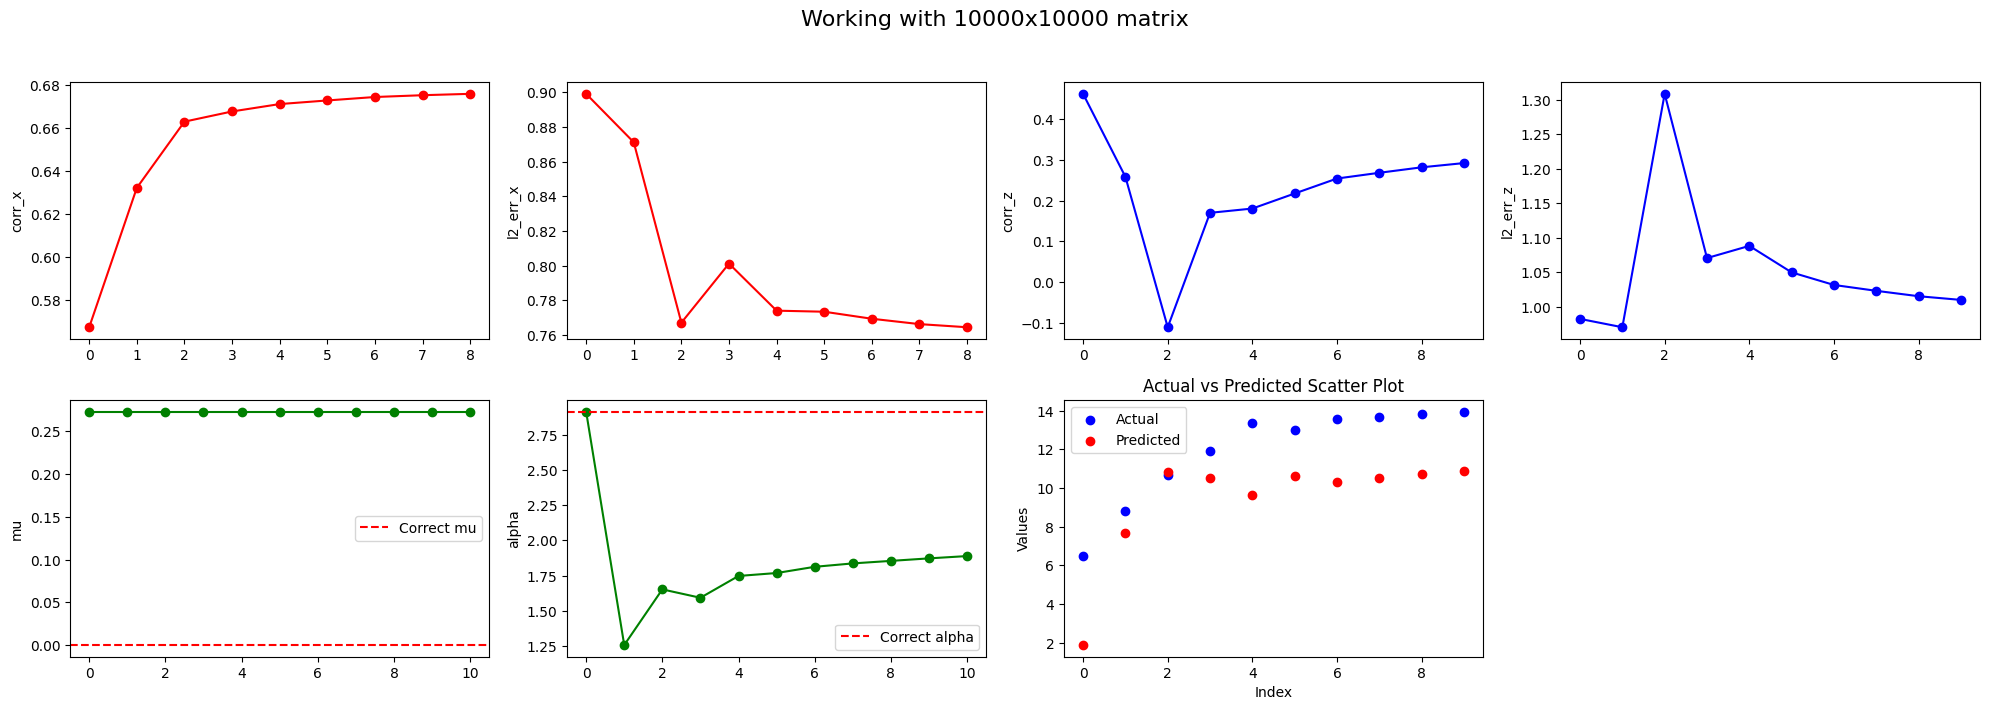

In [9]:
np.random.seed(42)
n=10000
m=10000
p=0.4
la=0.4
# This is where the sigma is defined. Note that the scope of this definition extends to gvamp
sigma=1
omega=1
h2=0.5
gam1 = 1e-2
tau1 = 1e-1

maxiter = 10
mu=np.full((n,1), 0) 
problem_instance = Problem(n=n, m=m, la=la, sigmas = [sigma], omegas=[omega], model='Weibull', mu=mu)
X,beta,y,alpha = sim_model(problem_instance,h2,p )
problem_instance.prior_instance.distribution_parameters['mu'] = np.mean(np.log(y)).reshape(-1, 1)

print("gam1 = ", gam1)
print("tau1 = ", tau1)
print("alpha = ", alpha)

# we start with an initialization that compleately complies with the assumptions
r1 = np.zeros((m,1))
#r1 = beta + random.normal(loc=0.0, scale=np.sqrt(1.0/gam1), size=[m,1])
p1 = np.zeros((n,1)) 
#p1 = X @ beta + random.normal(loc=0.0, scale=np.sqrt(1.0/tau1), size=[n,1])
problem_instance.prior_instance.distribution_parameters['alpha']=alpha

est, gam1, corrs_x, l2_errs_x, corrs_z, l2_errs_z, mus, alphas, a, ps, dl_dmus, z1_hats, x1_hats =  infere_con_grad(X, y, gam1, r1, tau1, p1, problem_instance, maxiter, beta, False, True)
plot_metrics(corrs_x, l2_errs_x, corrs_z, l2_errs_z, mus, alphas, dl_dmus, a, ps, mu[0][0], alpha, n, m)